[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


📚 Downloading: Alice's Adventures in Wonderland


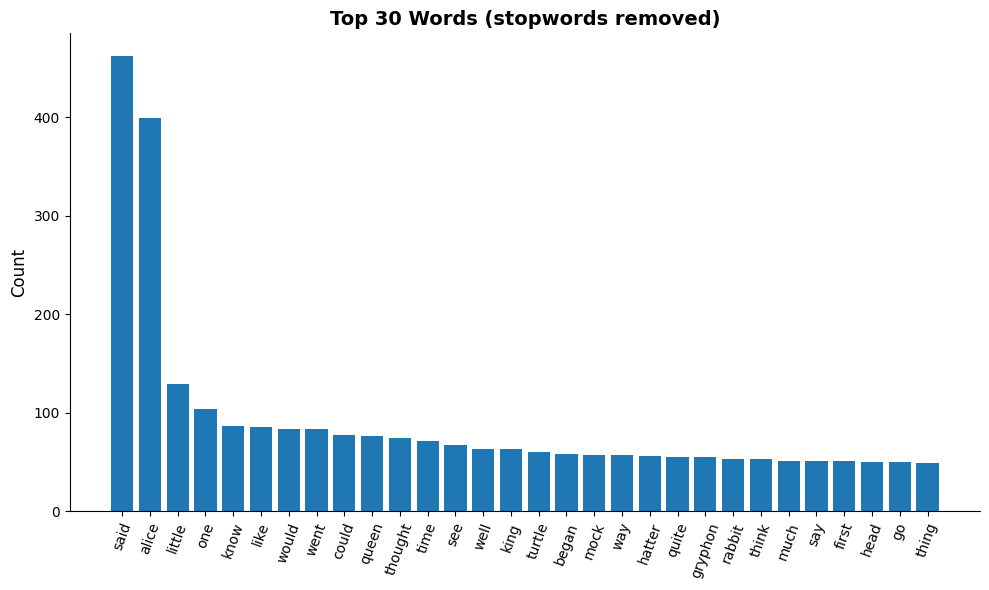

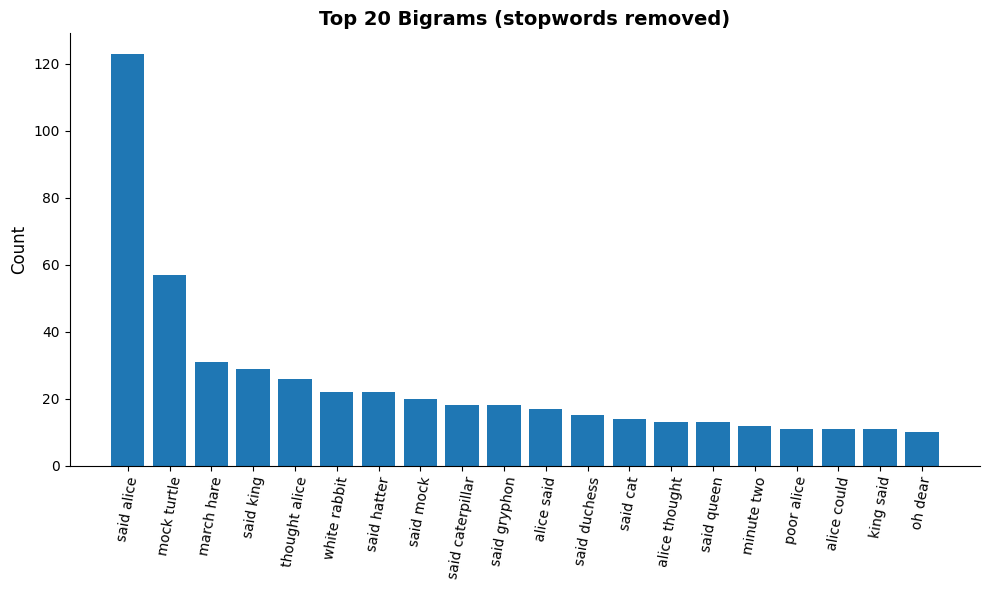

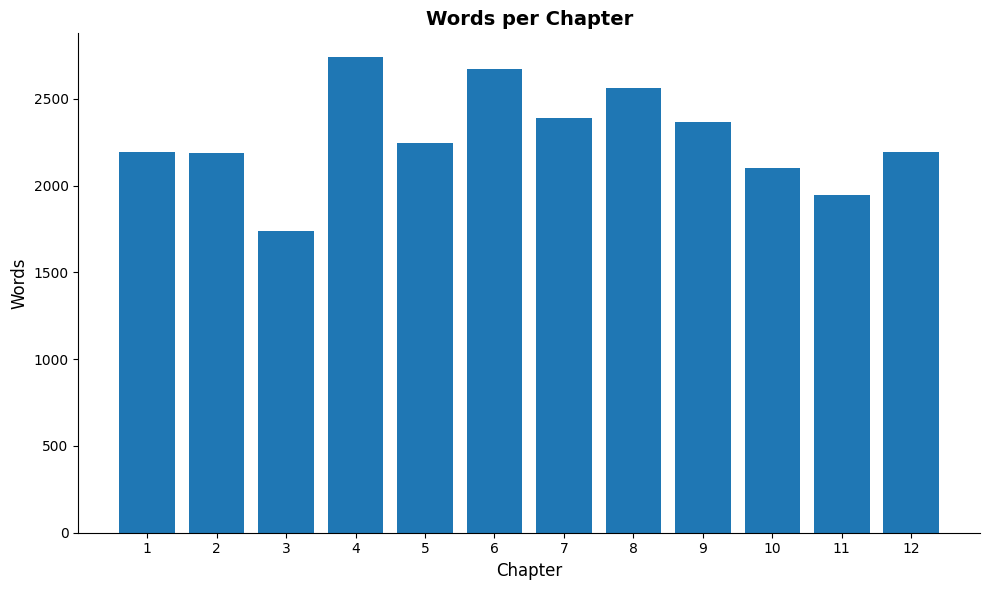

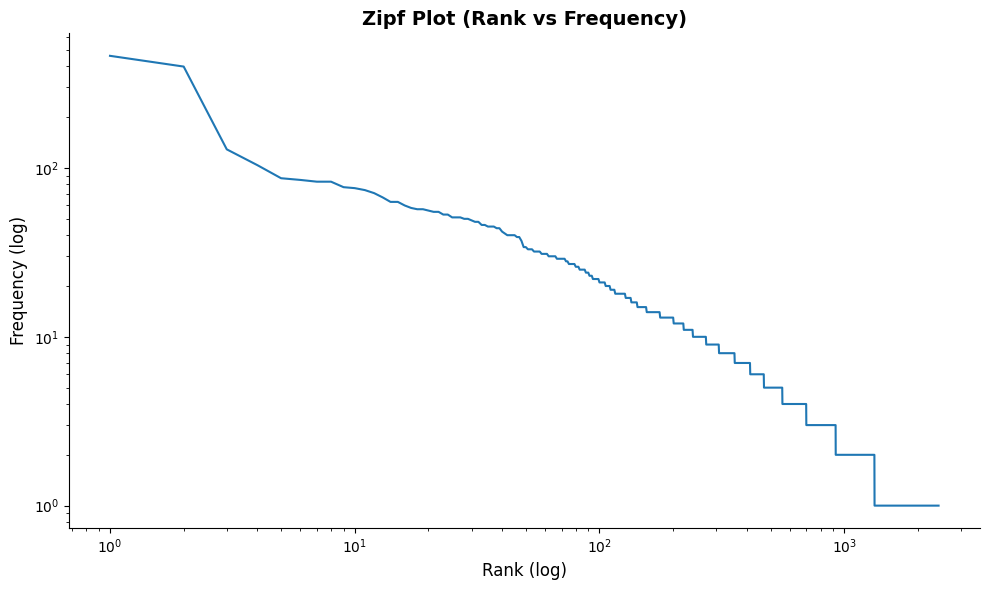

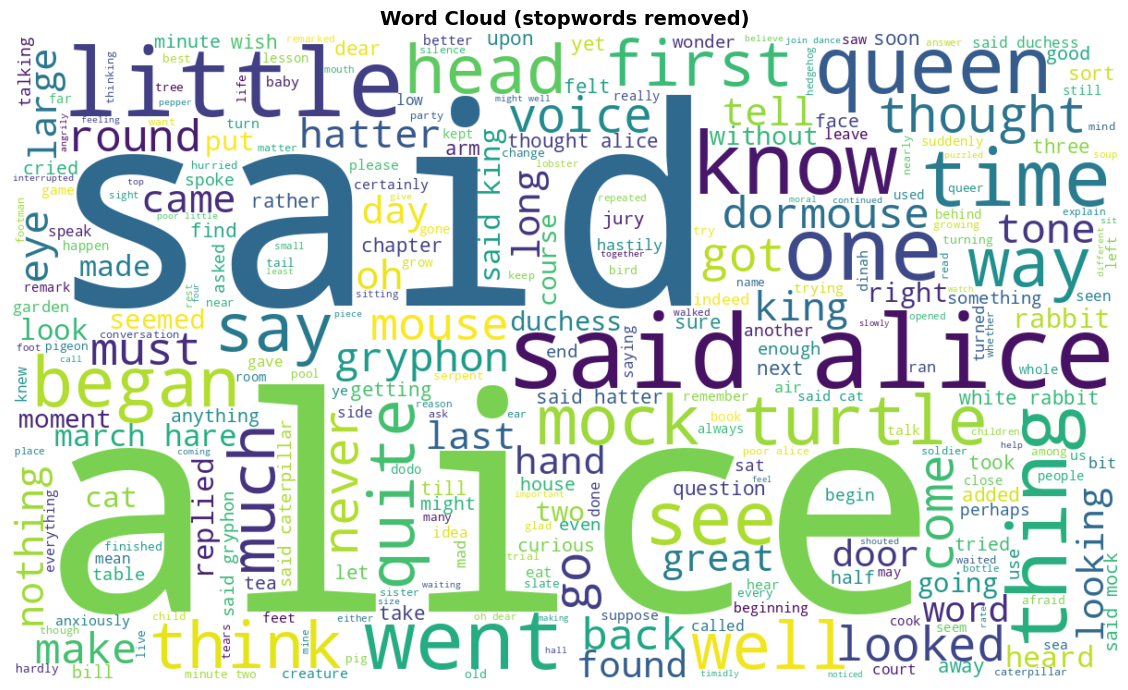


--- SUMMARY ---
Total tokens: 27,427
Vocabulary size: 2,575
Type-Token Ratio: 0.0939
Hapax count: 1,106
Average chapter length (words): 2278.0
Average chapter length (sentences): 81.4


In [1]:
"""
Alice in Wonderland — Text EDA Toolkit (Complete, Fixed for punkt_tab)
"""

# ==========================
# 0) Setup & Imports
# ==========================
import os
import re
import io
import string
from collections import Counter

import requests
import pandas as pd
from bs4 import BeautifulSoup

# NLTK setup
import nltk
try:
    _ = nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    _ = nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
try:
    _ = nltk.corpus.stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

# Viz
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titleweight': 'bold',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except Exception:
    WORDCLOUD_AVAILABLE = False

# ==========================
# 1) Config
# ==========================
BOOK_TITLE = "Alice's Adventures in Wonderland"
GUTENBERG_PAGE = "https://www.gutenberg.org/ebooks/11"
CANDIDATE_URLS = [
    "https://www.gutenberg.org/files/11/11-0.txt",
    "https://www.gutenberg.org/cache/epub/11/pg11.txt",
    "https://www.gutenberg.org/files/11/11-h/11-h.htm",
]

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ==========================
# 2) Helpers
# ==========================
GUTENBERG_START = re.compile(r"\*\*\*\s*START OF (?:THE|THIS) PROJECT GUTENBERG EBOOK.*?\n", re.I)
GUTENBERG_END   = re.compile(r"\*\*\*\s*END OF (?:THE|THIS) PROJECT GUTENBERG EBOOK.*", re.I | re.S)

CHAPTER_SPLIT_RE = re.compile(r"(?im)^(?:chapter\s+[ixvlcdm]+\.?|chapter\s+\d+\.?\s.*)$")

WORD_RE = re.compile(r"[a-zA-Z']+")
STOPWORDS = set(stopwords.words('english'))


def robust_fetch_text(urls):
    for url in urls:
        try:
            r = requests.get(url, timeout=30)
            r.raise_for_status()
            text = r.text
            if 'html' in r.headers.get('Content-Type', '') or url.lower().endswith(('.htm', '.html')):
                soup = BeautifulSoup(text, 'html.parser')
                for tag in soup(['script', 'style', 'header', 'footer', 'nav', 'figure', 'img']):
                    tag.decompose()
                text = soup.get_text("\n")
            return text
        except Exception:
            continue
    raise RuntimeError("Failed to fetch book text.")


def strip_gutenberg_boilerplate(text: str) -> str:
    m = GUTENBERG_START.search(text)
    if m:
        text = text[m.end():]
    text = GUTENBERG_END.sub("", text)
    return text.strip()


def split_into_chapters(text: str):
    lines = text.splitlines()
    indices = [i for i, line in enumerate(lines) if CHAPTER_SPLIT_RE.match(line.strip())]
    if not indices:
        return [text]
    chapters = []
    for j, start in enumerate(indices):
        end = indices[j + 1] if j + 1 < len(indices) else len(lines)
        chapters.append("\n".join(lines[start:end]).strip())
    return chapters


def normalize_sentence(s: str) -> str:
    s = re.sub(r"\s+", " ", s.strip()).lower()
    return s.strip(" .!?\"'")


def tokenize_words(text: str):
    return WORD_RE.findall(text.lower())


def ngrams(tokens, n=2):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# ==========================
# 3) Download & Clean
# ==========================
print(f"📚 Downloading: {BOOK_TITLE}")
raw = robust_fetch_text(CANDIDATE_URLS)
clean = strip_gutenberg_boilerplate(raw)

# ==========================
# 4) Chapters, Sentences, Words
# ==========================
chapters = split_into_chapters(clean)
chapter_sentences = [sent_tokenize(ch) for ch in chapters]
all_sentences = [s for ch in chapter_sentences for s in ch]

all_words = tokenize_words(clean)
words_no_stop = [w for w in all_words if w not in STOPWORDS]

# ==========================
# 5) Frequencies & Stats
# ==========================
unigram_counts_all = Counter(all_words)
unigram_counts_no_stop = Counter(words_no_stop)

bigrams_no_stop = ngrams(words_no_stop, 2)
bigram_counts = Counter(bigrams_no_stop)

norm_sentences = [normalize_sentence(s) for s in all_sentences]
sentence_counts = Counter(s for s in norm_sentences if len(s) >= 25)

chap_stats = []
for idx, (ch_text, sents) in enumerate(zip(chapters, chapter_sentences), start=1):
    ch_words = tokenize_words(ch_text)
    chap_stats.append({
        'chapter': idx,
        'num_sentences': len(sents),
        'num_words': len(ch_words),
        'num_chars': len(ch_text),
    })
chap_df = pd.DataFrame(chap_stats)

avg_len_words = chap_df['num_words'].mean() if not chap_df.empty else float('nan')
avg_len_sents = chap_df['num_sentences'].mean() if not chap_df.empty else float('nan')

vocab_size = len(set(all_words))
num_tokens = len(all_words)
type_token_ratio = vocab_size / num_tokens if num_tokens else float('nan')
hapax_count = sum(1 for w, c in unigram_counts_all.items() if c == 1)

ranked = sorted(unigram_counts_no_stop.items(), key=lambda kv: kv[1], reverse=True)
ranks = list(range(1, len(ranked) + 1))
frequencies = [f for _, f in ranked]

# ==========================
# 6) DataFrames & CSVs
# ==========================
TOP_K = 30
uni_df = pd.DataFrame(unigram_counts_no_stop.most_common(TOP_K), columns=['word', 'count'])
bi_df = pd.DataFrame([(" ".join(bg), c) for bg, c in bigram_counts.most_common(TOP_K)], columns=['bigram', 'count'])
sent_df = pd.DataFrame(sentence_counts.most_common(15), columns=['sentence (normalized)', 'count'])

uni_df.to_csv(os.path.join(OUT_DIR, 'top_unigrams.csv'), index=False)
bi_df.to_csv(os.path.join(OUT_DIR, 'top_bigrams.csv'), index=False)
chap_df.to_csv(os.path.join(OUT_DIR, 'chapter_stats.csv'), index=False)
sent_df.to_csv(os.path.join(OUT_DIR, 'top_sentences.csv'), index=False)

# ==========================
# 7) Pretty Visuals
# ==========================
plt.figure()
plt.bar(uni_df['word'], uni_df['count'])
plt.title(f"Top {TOP_K} Words (stopwords removed)")
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(bi_df['bigram'][:20], bi_df['count'][:20])
plt.title("Top 20 Bigrams (stopwords removed)")
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

if not chap_df.empty:
    plt.figure()
    plt.bar(chap_df['chapter'].astype(str), chap_df['num_words'])
    plt.title("Words per Chapter")
    plt.xlabel('Chapter')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

if len(frequencies) >= 2:
    plt.figure()
    plt.loglog(ranks, frequencies)
    plt.title("Zipf Plot (Rank vs Frequency)")
    plt.xlabel('Rank (log)')
    plt.ylabel('Frequency (log)')
    plt.tight_layout()
    plt.show()

if WORDCLOUD_AVAILABLE:
    wc = WordCloud(width=1200, height=700, background_color='white', max_words=300)
    wc.generate(" ".join(words_no_stop))
    plt.figure(figsize=(12,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud (stopwords removed)')
    plt.tight_layout()
    plt.show()

# ==========================
# 8) Summary
# ==========================
print("\n--- SUMMARY ---")
print(f"Total tokens: {num_tokens:,}")
print(f"Vocabulary size: {vocab_size:,}")
print(f"Type-Token Ratio: {type_token_ratio:.4f}")
print(f"Hapax count: {hapax_count:,}")
if not chap_df.empty:
    print(f"Average chapter length (words): {avg_len_words:.1f}")
    print(f"Average chapter length (sentences): {avg_len_sents:.1f}")
